# Automatic Number Plate Recognition in Shogun

#### By Abhijeet Kislay (GitHub ID: <a href='https://github.com/kislayabhi'>kislayabhi</a>)

This notebook is about performing <a href="http://en.wikipedia.org/wiki/Automatic_number_plate_recognition">ANPR</a> to detect automobile license plates in photographs taken between 1-2 metres from a car. We will be introduced to techniques related to <a href="http://en.wikipedia.org/wiki/Image_segmentation">image segmentation</a>, <a href="http://en.wikipedia.org/wiki/Feature_extraction">feature extraction</a>, <a href="http://en.wikipedia.org/wiki/Pattern_recognition">pattern recognition </a>, and two important pattern recognition algorithms <a href="http://en.wikipedia.org/wiki/Support_vector_machine">SVM</a> and <a href="http://en.wikipedia.org/wiki/Artificial_neural_network">ANN</a>. 

## Background

***Automatic Number Plate Recognition (ANPR)***, is a surveillance method that uses ***Optical Character Recognition (OCR)*** and other methods such as segmentations and
detection to read vehicle registration plates.

The best results in an **ANPR** system can be obtained with an infrared (IR) camera,
because the segmentation steps for detection and OCR segmentation are easy, clean,
and minimize errors. Sadly, we do not use IR photographs here. That is we are going to try and get same results with regular photographs only!

Each country has different license plate sizes and specifications; it is useful to know
these specifications in order to get the best results and reduce errors. The algorithms
used here are intended to explain the basics of **ANPR** and the specifications
for license plates from **Croatia** (Why? because I found it's license plate database fairly easily on the internet), but we can extend them to any country or specification.(check references for the link)

I have loaded few of those plates here.

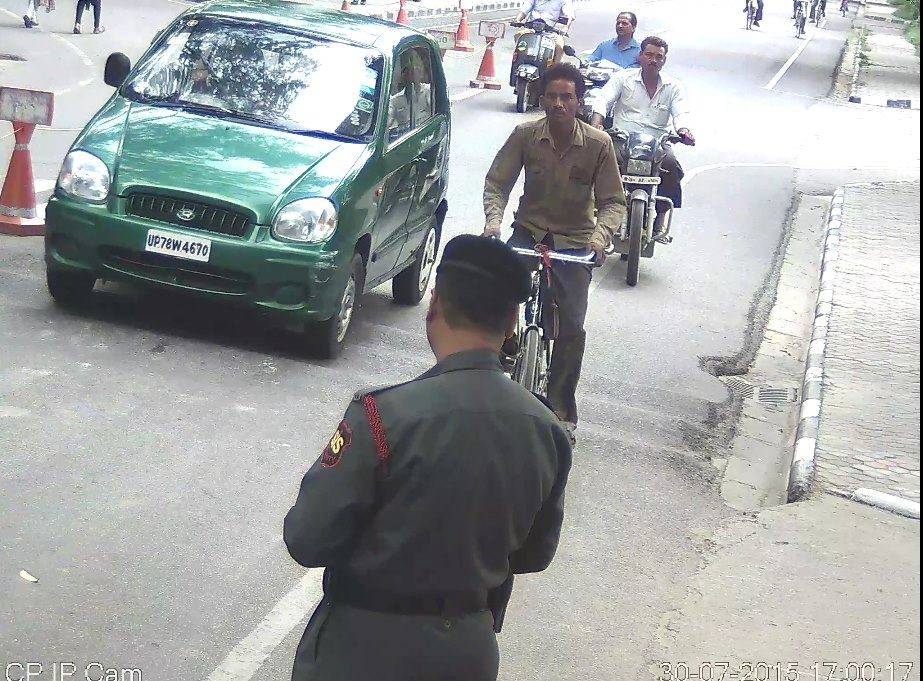

In [644]:
from IPython.display import Image

Image(filename='xx.jpg')
# clf = joblib.load('rfmodel.pkl')

The whole algorithmic approach is structured as following:
1. **Plate Detection**
2. **Segmentation**
3. **Classification**
4. **Plate Recognition**
5. **OCR Segmentation**
6. **Feature Extraction**
7. **OCR Classification**

We will go through each of these steps one by one.

## 1. Plate Detection

First load a car image. It's better to see what we are dealing with

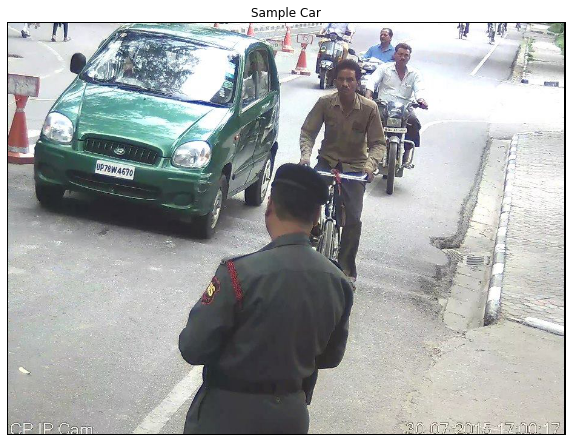

In [645]:
#Use the following function when reading an image through OpenCV and displaying through plt.
def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    
#import Opencv library
try:
    import cv2
except ImportError:
    print "You must have OpenCV installed"
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

plt.rcParams['figure.figsize'] = 10, 10 

# Actual Code starts here
plt.title('Sample Car')
image_path="xx.jpg"
carsample=cv2.imread(image_path)
showfig(carsample,None)

In this step we have to detect all the plates in the current camera frame. Two broad categories in which they can be defined are:

1. ** Segmentation**
2. **Classification**

### Segmentation

Segmentation is the process of dividing an image into multiple segments. This
process is to simplify the image for analysis and make feature extraction easier.

One important feature that we can exploit from Number plates are the high number of vertical edges. But before that, we need to do some handy preprocessing of the current image namely:

1. **grayscale conversion** : color won't help us in this task
2. **Remove Noise** : A 5x5 Gaussian blur to remove unwanted vertical edges

To find the vertical edges, we will use a Sobel filter and find its first horizontal derivative.

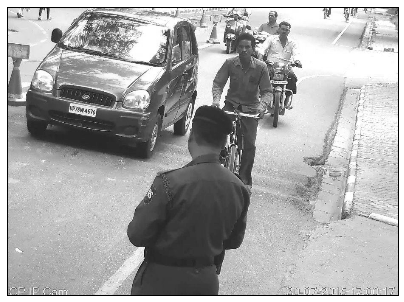

In [646]:
plt.rcParams['figure.figsize'] = 7,7

# convert into grayscale
gray_carsample=cv2.cvtColor(carsample, cv2.COLOR_BGR2GRAY)
showfig(gray_carsample,plt.get_cmap('gray'))

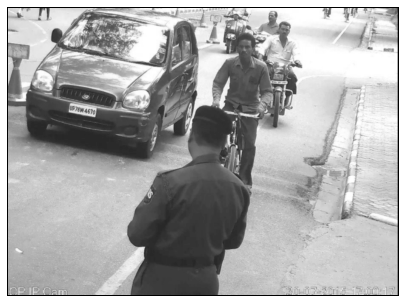

In [647]:
# blur the image
blur=cv2.GaussianBlur(gray_carsample,(5,5),0)
showfig(blur, plt.get_cmap('gray'))

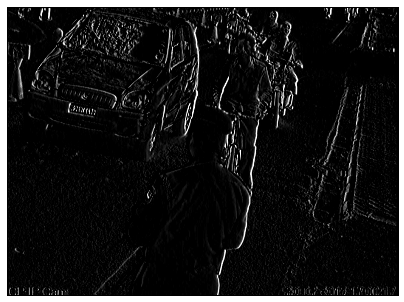

In [648]:
# find the sobel gradient. use the kernel size to be 3
sobelx=cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=3)
showfig(sobelx, plt.get_cmap('gray'))

After a Sobel Filter, we apply a threshold filter to obtain a binary image with a threshold value obtained through Otsu's Method.Otsu's algorithm needs an 8-bit input
image and Otsu's method automatically determines the optimal threshold value:

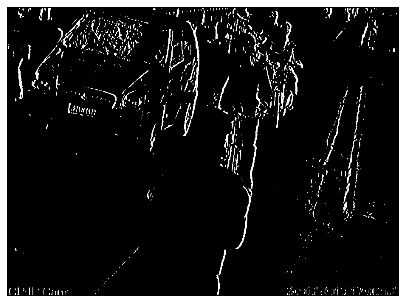

In [649]:
#Otsu thresholding
_,th2=cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
showfig(th2, plt.get_cmap('gray'))

By applying a close morphological operation, we can remove blank spaces between
each vertical edge line, and connect all regions that have a high number of edges. In
this step we have the possible regions that can contain plates.

First we define our structural element to use in our morphological operation. We will
use the **getStructuringElement()** function to define a structural rectangular element
with a 23 x 2 dimension size in our case; this may be different in other image sizes and use this structural element in a close morphological operation using the **morphologyEx()** function:

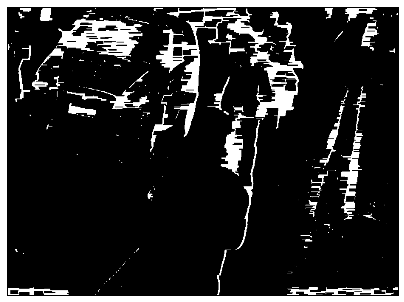

In [650]:
#Morphological Closing
se=cv2.getStructuringElement(cv2.MORPH_RECT,(18,2))
closing=cv2.morphologyEx(th2, cv2.MORPH_CLOSE, se)
showfig(closing, plt.get_cmap('gray'))

After all these preprocessing steps, we have regions in the image that have the possibility of containing license plates. 

This calls for the use of **findContours()** function. This function retrieves the contours of a binary image. We only need the external contours. Hierarchical relationships between the contours does not matter here but later in this notebook, we will be discussing it in a bit more detail.

In [651]:
im2,contours,_=cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Lets visualize all the detected contours approximated to there  rectangular BoundingBoxes. OpenCV has **minAreaRect()** function exactly for this task. We use **BoxPoints()** function to extract all the four co-ordinates of the rectangle which is then used to draw the boundingbox.

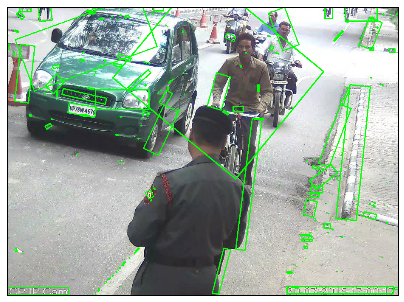

In [652]:
for cnt in contours:
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    cv2.drawContours(carsample, [box], 0, (0,255,0),2)
showfig(carsample, None)

There are too many false positives! Well, Lets try to remove the outliers by validating against their area and aspect ratio. 

* A normal number plate should have an aspect ratio of atleast more than 3.
* Outstanding area should be around 8000. Lets make a rough range(maybe there's a exception) of area between 3000 to 16000 pixels. We don't want the actual number plate to disappear!

To carry out this task we define a separate function.

236


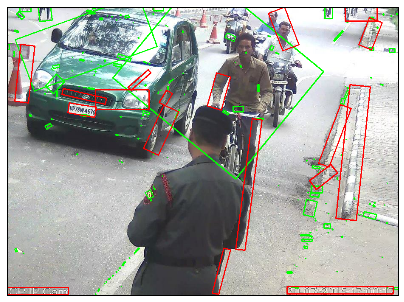

In [653]:
#validate a contour. We validate by estimating a rough area and aspect ratio check.
def validate(cnt):    
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>2) & (height>width)) | ((width/height>2) & (width>height))):
            if((height*width<30000) & (height*width>400)): 
                output=True
    return output

#Lets draw validated contours with red.
for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt)  
        box=cv2.boxPoints(rect) 
        box=np.int0(box)  
        cv2.drawContours(carsample, [box], 0, (0,0,255),2)
showfig(carsample, None)
print len(contours)

This has improved the results but we want to do still better.
But mind it. We are not going to get more strict and remove those few outliers left using the above mentioned checks! That will be killing the robustness of the system against any new car image!

We need to exploit something other than this. You may see that our License Plates generally have a white background. That means we can use a **flood fill** algorithm.

**flood fill** is very similar to the old Fill color that you might have used in MS Paint or other drawing programs! It tries to spread your choosen color from the point of origin to every direction untill it faces a tangible boundary preventing it to go any further.

For applying this algorithm, we need to have the origin (also known as **seeds**). Since we have no idea how to choose a specific **seed** within these validated rectangles, we will randomize it and hope that atleast one of them suceeds in exploiting the white background of a actual License Plate and **floodfills** a considerable chunk of it

In [654]:
# defining a function doing this will come handy.
# def generate_seeds(centre, width, height):
#     minsize=int(min(width, height))
#     seed=[None]*10
#     for i in range(10):
#         random_integer1=np.random.randint(1000)
#         random_integer2=np.random.randint(1000)
#         seed[i]=(centre[0]+random_integer1%int(minsize/2)-int(minsize/2),centre[1]+random_integer2%int(minsize/2)-int(minsize/2))
#     return seed
def generate_seeds(centre, width, height):
    minsize=int(min(width, height))
    seed=[None]*10
    for i in range(10):
        random_integer1=np.random.randint(1000)
        random_integer2=np.random.randint(1000)
        x = centre[0]+random_integer1%int(minsize/2)-int(minsize/2)
        y = centre[1]+random_integer2%int(minsize/2)-int(minsize/2)
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        seed[i]=(x,y)
    return seed

We want to select the white region and we need several seeds to touch at least one
white pixel. Now for each seed that we get from the previous function, we use a **floodFill()** function to draw a new mask image to store the new closest cropping region

The **floodFill()** function fills a connected component with color into a mask image starting from a seed point, and sets maximal lower and upper brightness/color difference between the pixel to fill.

The required parameters that are needed:
* **newval**: the new color that we want to put in
* **lodiff & updiff**: the maximal lower and maximal upper brightness/color difference
* The **flag** parameter is a combination of **Lower bits** and **Upper bits**

Here:
* **Lower bits** contain the connectivity value, It determines which neighbours of a pixel are considered.
* **Upper bits** is here a combination of **CV_FLOODFILL_FIXED_RANGE**  and **CV_FLOODFILL_MASK_ONLY** 
    
Here:
* **CV_FLOODFILL_FIXED_RANGE** sets the difference between the current pixel and the seed pixel.
* **CV_FLOODFILL_MASK_ONLY** will only fill the image and not change the image itself.

In [655]:
#masks are nothing but those floodfilled images per seed.
def generate_mask(image, seed_point):
    h=carsample.shape[0]
    w=carsample.shape[1]
    #OpenCV wants its mask to be exactly two pixels greater than the source image.
    mask=np.zeros((h+2, w+2), np.uint8)
    #We choose a color difference of (50,50,50). Thats a guess from my side.
    lodiff=50
    updiff=50
    connectivity=4
    newmaskval=255
    flags=connectivity+(newmaskval<<8)+cv2.FLOODFILL_FIXED_RANGE+cv2.FLOODFILL_MASK_ONLY
    _=cv2.floodFill(image, mask, seed_point, (255, 0, 0),
                    (lodiff, lodiff, lodiff), (updiff, updiff, updiff), flags)
    return mask

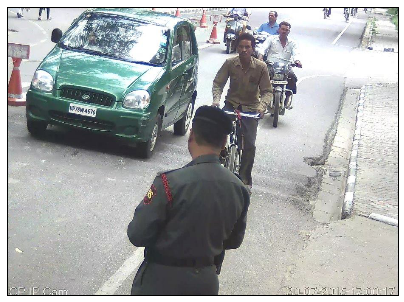

In [656]:
# we will need a fresh copy of the image so as to draw masks.
carsample_mask=cv2.imread(image_path)
showfig(carsample_mask,None)
# for viewing the different masks later
mask_list=[]
for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt) 
        centre=(int(rect[0][0]), int(rect[0][1]))
        width=rect[1][0]
        height=rect[1][1]
        seeds=generate_seeds(centre, width, height)
        #now for each seed, we generate a mask
        for seed in seeds:
            # plot a tiny circle at the present seed.
            cv2.circle(carsample, seed, 1, (0,0,255), -1)
            # generate mask corresponding to the current seed.
            mask=generate_mask(carsample_mask, seed)
            mask_list.append(mask)  
        #print len(mask_list)

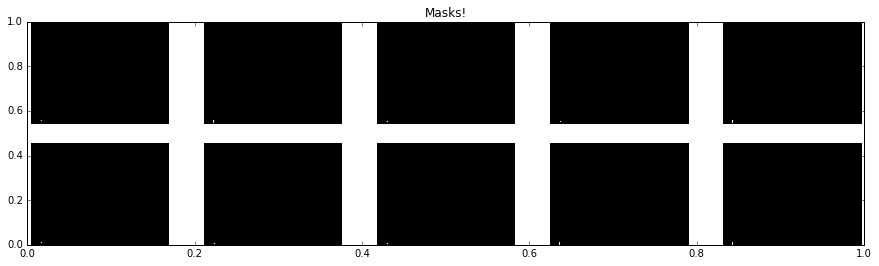

In [657]:
#We plot 1st ten masks here
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
plt.title('Masks!')
for mask_no in range(10):
    fig.add_subplot(2, 5, mask_no+1)
    showfig(mask_list[mask_no], plt.get_cmap('gray'))

We will use our area and aspect ratio checks again on the approximated bounding boxes of the above masks!

180
39


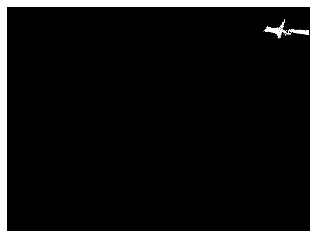

In [658]:
validated_masklist=[]
mask_num =0 
mask_no = 0
print(len(mask_list))
#newmasklist  = mask_list[20:30]
for mask in mask_list:
    contour=np.argwhere(mask.transpose()==255)
    if validate(contour):
        validated_masklist.append(mask)
        mask_no = mask_no +1
    
        #fig.add_subplot(2, 5, mask_no)
        showfig(mask,plt.get_cmap('gray'))
print(len(validated_masklist))

In [659]:
try:
    assert (len(validated_masklist)!=0)
except AssertionError:
    print "No valid masks could be generated"

Most probable masks are now here. But there may be those cases where almost same masks are repeated. This is possible as the seeds were random and there can always be more than 1 seed producing the same mask.

27


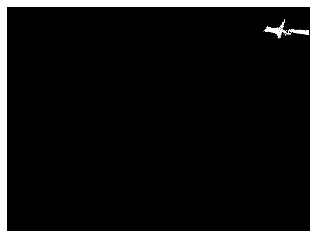

In [660]:
# We check for repetation of masks here.
#from scipy import sum as
#import scipy.sum as scipy_sum
# This function quantifies the difference between two images in terms of RMS.
def rmsdiff(im1, im2):
    diff=im1-im2
    output=False
    if np.sum(abs(diff))/float(min(np.sum(im1), np.sum(im2)))<0.01:
        output=True
    return output

# final masklist will be the final list of masks we will be working on.
final_masklist=[]
index=[]
for i in range(len(validated_masklist)):
    for j in range(i+1, len(validated_masklist)):
        if rmsdiff(validated_masklist[i], validated_masklist[j]):
            index.append(j)
for mask_no in list(set(range(len(validated_masklist)))-set(index)):
    final_masklist.append(validated_masklist[mask_no])
    showfig(validated_masklist[mask_no], plt.get_cmap('gray'))
print(len(final_masklist))
#showfig(carsample_mask,plt.get_cmap('gray'))    

Now that the segmentation process is finished and we have valid regions, we can remove any possible rotation, crop the image region, resize the image, and equalize the light of cropped image regions.

27
size before
(56, 225)
size before
(22, 63)
size before
(21, 63)
size before
(17, 61)
size before
(173, 84)
size before
(44, 181)
size before
(39, 170)
size before
(83, 186)
size before
(102, 254)
size before
(24, 74)
size before
(51, 184)
size before
(89, 231)
size before
(52, 156)
size before
(22, 49)
size before
(279, 102)
size before
(53, 120)
size before
(21, 47)
size before
(59, 244)
size before
(23, 63)
size before
(93, 210)
size before
(64, 223)
size before
(93, 45)
size before
(44, 118)
size before
(52, 136)
size before
(56, 137)
size before
(67, 147)
size before
(55, 136)


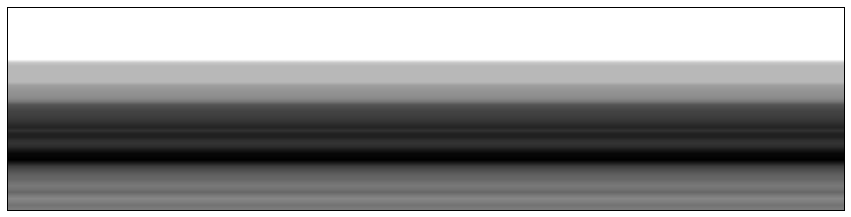

In [661]:
cropped_images=[]
orig_rects = []
orig_rects_clear = []
images = []
print len(final_masklist)
i=0
countl = 0
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
import math
for mask in final_masklist:
    #mask = final_masklist[0]
    
    imgtest = cv2.imread(image_path)
    contour=np.argwhere(mask.transpose()==255)
#     print contour.shape
    rect=cv2.minAreaRect(contour)
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    #print box
    #print(rect)
    width=(rect[1][0])
    height=(rect[1][1])
    #print(width, height)
    centre=(float(rect[0][0]), float(rect[0][1]))
    size = (height, width)
    angle = int(rect[2])
    #print(angle)
#     if angle < -45 :
#         angle += 90
#         size = (width,height)
#     cv2.drawContours(imgtest,[rect],0,(0,0,255),2)
    #print(angle)
#     print(box)
    if box[0][0]>box[1][0] and box[0][1]>box[1][1] and box[0][0]>box[2][0]:
        angle =math.degrees(math.atan((float(box[3][1])-box[2][1])/(box[3][0]-box[2][0])))
        angle =angle
#         print('hey')
    elif box[0][0]==box[1][0] or box[0][1]==box[1][1]:
        angle = 0
#         print("oh shit")
        if height<width:
            height, width = width, height
    elif box[0][0]>box[1][0] and box[0][1]>box[1][1] and box[0][0]<box[2][0]:
        angle =math.degrees(math.atan((float(box[1][1])-box[2][1])/(box[2][0]-box[1][0])))
        if height<width:
            height, width = width, height
#             print("yoo")
#         print('yo')
        #print(height, width)
#     print(angle)
    width, height = int(width), int(height)        
    rot = cv2.getRotationMatrix2D(centre,angle,1)
    dim = imgtest.shape
    #print dim
    height1 = imgtest.shape[0]
    width1 = imgtest.shape[1]
    orig_rect = cv2.warpAffine(imgtest,rot,(height1,width1))
    cropped_image = cv2.getRectSubPix(orig_rect,(height,width),centre)
    cropped_image=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    cropped_image=cv2.equalizeHist(cropped_image)
    cropped_image_clear=np.copy(cropped_image)
    print "size before"
    print cropped_image_clear.shape
    cropped_image = cv2.resize(cropped_image,(260,63))
    orig_rects.append(cropped_image)
    orig_rects_clear.append(cropped_image_clear)
    

    countl+=1
    showfig(cropped_image,plt.get_cmap('gray'))
    images.append(imgtest)

#     orig_rect = cv2.resize(orig_rect,(63,260))
#     plt.imshow(orig_rect,plt.get_cmap('gray'))
#     print size,centre,anglea

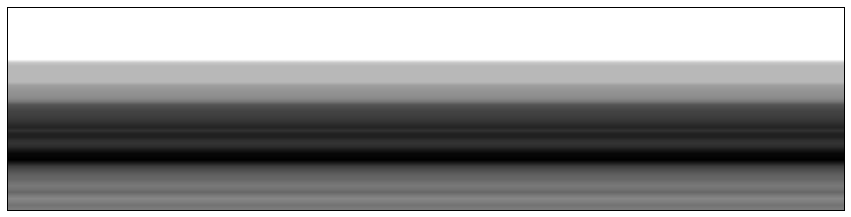

In [662]:
_=plt.subplots_adjust(hspace=0.000)
number_of_subplots=len(orig_rects)
for i,v in enumerate(xrange(number_of_subplots)):
    v = v+1
#     ax1 = plt.subplot(number_of_subplots,1,v)
    showfig(orig_rects[i], plt.get_cmap('gray'))
    
    cv2.imwrite('out'+str(i)+'.jpg',orig_rects[i])

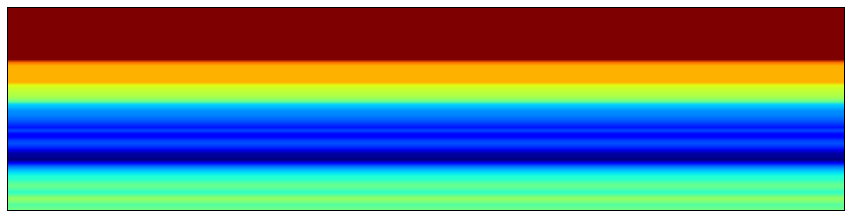

In [663]:
for ima in orig_rects:
    showfig(ima,None)
# for img in images:
#     showfig(img,None)

In [664]:
#     M = cv2.getRotationMatrix2D(centre,angle, 1.0)
#     orig_rect = cv2.getRectSubPix(carsample_mask, size, centre)
#     cropped_image = cv2.warpAffine(orig_rect, M, size)
    #check for 90 degrees rotation
#     if ((width/float(height))>1):
#         # crop a particular rectangle from the source image
#         cropped_image=cv2.getRectSubPix(carsample_mask, (width+50, height+50), centre)
#     else:
#         # crop a particular rectangle from the source image
#         cropped_image=cv2.getRectSubPix(carsample_mask, (height+50, width+50), centre)

    # convert into grayscale
#     cropped_image=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
#     # equalize the histogram
#     cropped_image=cv2.equalizeHist(cropped_image)
#     # resize to 260 cols and 63 rows. (Just something I have set as standard here)
# #     cropped_image=cv2.resize(cropped_image, (260, 63))
#     cropped_images.append(cropped_image)

Lets see these cropped regions.

In [665]:
_=plt.subplots_adjust(hspace=0.000)
number_of_subplots=len(cropped_images)
# for i,v in enumerate(xrange(number_of_subplots)):
#     v = v+1
#     ax1 = plt.subplot(number_of_subplots,1,v)
#     showfig(cropped_images[i], plt.get_cmap('gray'))

### Classification

After we preprocess and segment all possible parts of an image, we need now to decide if each segment is or is not a license plate. To do this, we will use Shogun's Support Vector Machines Framework.

Basically we will be training a 2 class LibSVM. One class for positive training image of License Plate and other class for the negatives.

I cropped almost 198 positive license plates images from the before mentioned database. Along with it, a set of 79 negative images are also cropped. These are already histogram equalized and reshaped into a size of 63 rows and 260 columns.(I have choosen this as the standard here)  

Lets see a part of it.

In [666]:
# import os
# def get_imlist(path):
#     return [[os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]]


# training_sample=[]  
# #We plot 1st ten positive and negative license plates here
# path_train='../../../data/ANPR/svm_train/positive/'
# filenames=np.array(get_imlist(path_train))
# for i in range(10):
#     temp=cv2.imread(filenames[0][i])
#     temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
#     training_sample.append(temp)
# path_train='../../../data/ANPR/svm_train/negative/'
# filenames=np.array(get_imlist(path_train))
# for i in range(10):
#     temp=cv2.imread(filenames[0][i])
#     temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
#     training_sample.append(temp)
    
# plt.rcParams['figure.figsize'] = 15,4
# fig = plt.figure()
# plt.title('first 10 are positives and rest 10 are negatives')
# for image_no in range(20):
#     fig.add_subplot(4, 5, image_no+1)
#     showfig(training_sample[image_no], plt.get_cmap('gray'))

In [667]:
import re
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.tree import DecisionTreeClassifier as dt
import cv2
import numpy as np
import os
from os import listdir
ppc = (4,4)
cpb = (3,3)
final_images = []
hog_image = []
if (len(orig_rects)>0):
    clf = joblib.load('model/model.pkl')
    for i in range(0,len(orig_rects)):
        testimg = orig_rects[i]
        hog_image.append(hog(testimg))
    hog_image = np.array(hog_image)
    y_pred = clf.predict(hog_image)
    for i in range(0,len(y_pred)):    
        if y_pred[i] == 1 :
            final_images.append(orig_rects_clear[i])
    print "len:"
    print len(orig_rects)
    print len(final_images)

len:
27
2


Below is function **get_svm()**. It will initialize a 2 class LibSVM on the training and testing dataset.

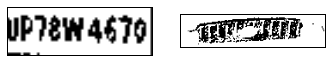

In [668]:
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
countl = 0
for i in range(0,len(final_images)):
#     ax1 = plt.subplot(number_of_subplots,1,v)
    # showfig(orig_rects[i], plt.get_cmap('gray'))

#     cv2.imwrite('testout/'+loc.replace('/',' ').strip('.jpg')+str(count)+'.jpg',final_images[i])
    fig.add_subplot(2, 5, countl+1)
    countl+=1
#    ret,final_images[i] = cv2.threshold(final_images[i],127,255,0)
    _,final_images[i]=cv2.threshold(final_images[i],70, 255, cv2.THRESH_BINARY)
#     _,th2=cv2.threshold(final_images[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    showfig(final_images[i],plt.get_cmap('gray'))
    

For each output of the **findContours()** function, we validate it with the aspect ratio checks and apply ANN over it.

12
8


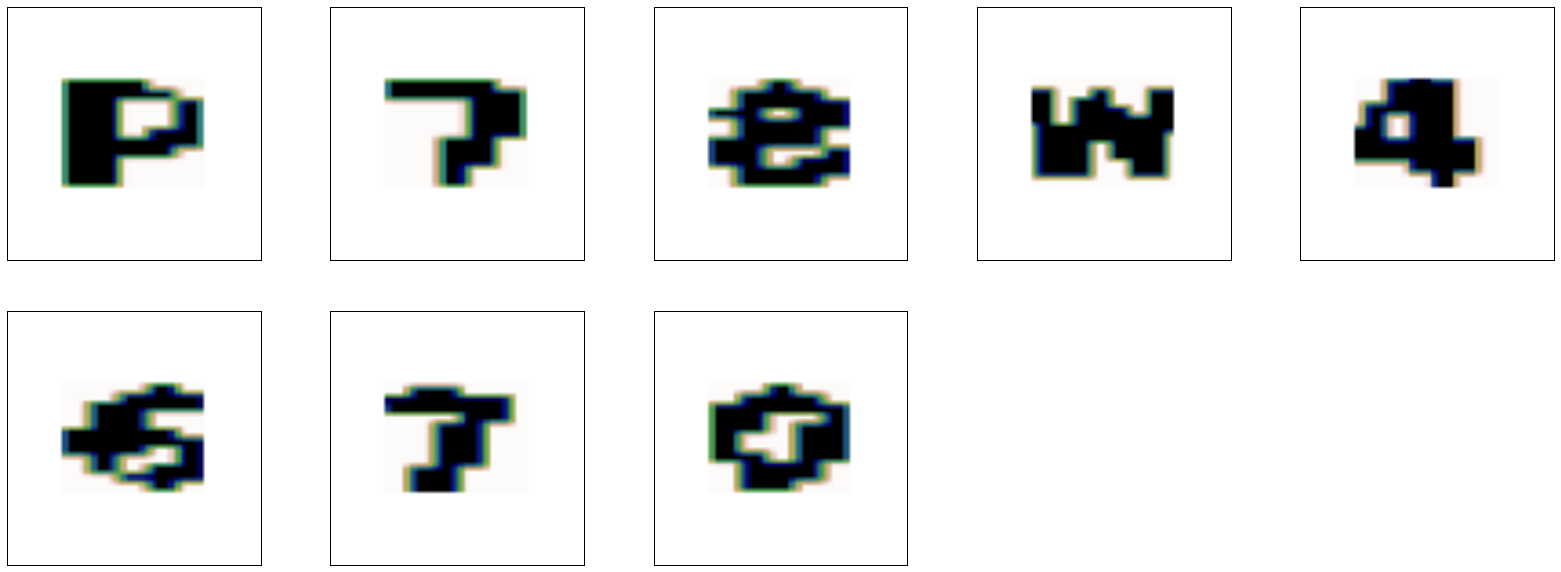

In [676]:
from PIL import Image
import PIL.ImageOps 

def showfig2(image, ucmap):
    imgplot=plt.imshow(image, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

def validate_ann(cnt):
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box) 
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>1.01) & (height>width)) | ((width/height>1.01) & (width>height))):
            if((height*width<1700) & (height*width>100)):
                if((max(width, height)<80) & (max(width, height)>20)):
                    output=True
    return output

background_image = []
sample_images=[]

# showfig(final_images[0], plt.get_cmap('gray'))
for i in range(1):
#     final_images[i]=np.array(final_images[i])
#     img = Image.fromarray(np.uint8(cm.gist_earth(final_images[i])*255))
#     #img = Image.eval(img, lambda(x):255-x)
# #             showfig2(img, plt.get_cmap('gray'))
#     img_w, img_h = img.size
#     full_background = Image.new('RGBA', (img_w+10,img_h+10), (255, 255, 255, 255))
#     bg_w, bg_h = background.size
#     offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
#     full_background.paste(img, offset)
#     final_images[i]=full_background
#     showfig(final_images[i], plt.get_cmap('gray'))
    working_image=np.copy(final_images[i])
    original=np.copy(final_images[i])
#     showfig(working_image, plt.get_cmap('gray'))
#     ret,thresh = cv2.threshold(imgray,127,255,0)
    original = cv2.resize(original, (260,63), interpolation=cv2.INTER_AREA) 
    working_image = cv2.resize(working_image, (260,63), interpolation=cv2.INTER_AREA)
# #     showfig(original, plt.get_cmap('gray'))
    im2, contours, hierarchy = cv2.findContours(original,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
#     working_image=np.uint8(image1)
    #we follow same preprocessing routines
#     working_image=np.resize(np.uint8(working_image),(63,260))
#     working_image=cv2.cvtColor(working_image,cv2.COLOR_BGR2GRAY);
# #     working_image=np.resize(np.uint8(working_image),(63,260))
    
#     working_image=cv2.equalizeHist(working_image)
#     showfig(working_image, plt.get_cmap('gray'))
#     working_image=cv2.GaussianBlur(working_image,(5,5),0)
#     _,th2=cv2.threshold(working_image, 0, 255, cv2.THRESH_BINARY_INV)
#     sobelx=cv2.Sobel(working_image, cv2.CV_8U, 1,0, ksize=3)
#    showfig(sobelx, plt.get_cmap('gray'))
#     _,th2=cv2.threshold(working_image,0, 255, cv2.THRESH_BINARY_INV)
# #     showfig(th2, plt.get_cmap('gray'))
#     contours=np.copy(th2)
#     crop_copy=np.copy(th2)
#     img,contours,_=cv2.findContours(original, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# #     cv2.drawContours(img, contours, -1, (0,255,0), 3)
# #     showfig(original, plt.get_cmap('gray'))

    print len(contours)
#     for cnt in contours:
#         rect=cv2.minAreaRect(cnt)  
#         box=cv2.boxPoints(rect) 
#         box=np.int0(box)
#        cv2.drawContours(original, [box], 0, (255,255,255),1)
#     showfig(original, plt.get_cmap('gray'))
# #     showfig(img, plt.get_cmap('gray'))
    count = -1
    cropped_images_new=[]
    x_cord=[]
#     plt.rcParams['figure.figsize'] = 39, 30
#     fig = plt.figure()   
    count = 0
    for index,cnt in enumerate(contours):
       
        if (validate_ann(cnt)):
            count = count + 1
            rect=cv2.minAreaRect(cnt)
            box=cv2.boxPoints(rect)
            box=np.int0(box)
            x_cord.append(box[0][0])
            # cv2.drawContours(working_image, [box], 0, (0, 255, 0),1)
            centre=rect[0]
            cropped=cv2.getRectSubPix(working_image,(int(min(rect[1])), int(max(rect[1]))) , centre)
            #showfig(cropped,plt.get_cmap('gray'))
            width,height=cropped.shape
#             print "before"
#             print cropped.shape
#             if(not(width/height>4 or height/width>4)):
#                 cropped=cv2.resize(cropped, (height,height), interpolation=cv2.INTER_AREA)  
#             print "After"
#             print cropped.shape
#             cropped = np.array(cropped)
#             cropped = np.invert(cropped)
#             showfig(working_image, plt.get_cmap('gray'))
#             print "entered"
#             print(cropped)
#             fig.add_subplot(2, 5,count)
#             showfig(cropped, plt.get_cmap('gray'))
            
            cropped_resize=cv2.resize(cropped, (39,30), interpolation=cv2.INTER_AREA)
            cropped_images_new.append(cropped_resize)

#             print cropped.shape
#             _, th2=cv2.threshold(cropped_resize, 70, 255, cv2.THRESH_BINARY)
#     print len(cropped_images_new)
           
             
            img = Image.fromarray(np.uint8(cm.gist_earth(cropped_resize)*255))
            #img = Image.eval(img, lambda(x):255-x)
#             showfig2(img, plt.get_cmap('gray'))
            img_w, img_h = img.size
            background = Image.new('RGBA', (70, 70), (255, 255, 255, 255))
            bg_w, bg_h = background.size
            offset = ((bg_w - img_w) / 2, (bg_h - img_h) / 2)
            background.paste(img, offset)
#            cropped_resize=cv2.resize(background, (40,40), interpolation=cv2.INTER_AREA)
#             background = background.resize((40, 40), Image.ANTIALIAS)
#             background = np.array(background)
#             raw_image=np.copy(background)
#             background = cv2.cvtColor(background,cv2.COLOR_BGR2GRAY);
#             background=cv2.resize(background,(28,28), interpolation=cv2.INTER_AREA)
            #Do a hard thresholding.
            
#             _,th2=cv2.threshold(background, 70, 255, cv2.THRESH_BINARY)
            
            #generate features
#             th2 = hog(th2)    
#             sample=th2.flatten()
            
#             inverted = PIL.ImageOps.invert(background)#Image.eval(background, lambda(x):255-x)
            
            background_image.append(background)
#             sample_images.append(sample)
    
    x_cord = np.array(x_cord)
    sort_x_cord = np.argsort(x_cord)
plt.rcParams['figure.figsize'] = 28, 10
fig = plt.figure()    

# # y_pred = clf.predict(sample_images)
# # print y_pred
print len(background_image)
for crop_img in range(len(background_image)):
    fig.add_subplot(2, 5,crop_img+1)
#     tmp_array=[]
    showfig2(background_image[sort_x_cord[crop_img]], plt.get_cmap('gray'))
    cv2.imwrite('./chars/'+str(crop_img)+'.jpg',background_image[sort_x_cord[crop_img]])
#     tmp_array.append()


### References:

* Mastering OpenCV with Practical Computer Vision Projects, Ch-5
* Automatic license plate recognition by Shyang-Lih Chang
* A Neural Network Based Artificial Vision System for Licence Plate Recognition by Sorin Draghici
* Image database : http://www.zemris.fer.hr/projects/LicensePlates/english/results.shtml